In [1]:
%load_ext autoreload
%autoreload 2

%pylab notebook
%matplotlib inline
from pylab import *
from scipy.optimize import curve_fit

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random', 'power', 'fft']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
rcParams['figure.dpi'] = 100
rcParams['figure.facecolor'] = 'white'

In [3]:
import sys, numpy as np, scipy as sc, warnings, os, healpy as H
sys.path.append('../DRAFT/modules/')
import foregrounds as fg, misc, flatsky, misc, exp_specs

#import matplotlib.cbook
warnings.filterwarnings('ignore',category=RuntimeWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=matplotlib.cbook.mplDeprecation)
#warnings.filterwarnings('ignore', category=OptimizeWarning)

In [4]:
result_fname = 'results/splat_hitmask_galmask_galdustcl.npy'
freq = 145 #GHz
lmax = 512
#which_spec = 'TT'
which_spec = 'EE'
beam_val = 1.4 #S4-Wide beam - Note that the pySM sims have used S4-Wide beam and not the delensing LAT beam
bl = H.gauss_beam(np.radians(beam_val/60.), lmax = lmax-1)
spec_ind_dict = {'TT':0, 'EE':1, 'BB':2, 'TE':3, 'EB':4, 'TB':5}
spec_ind = spec_ind_dict[which_spec]

In [5]:
#read results file
result_dict = np.load(result_fname, allow_pickle=True).item()
min_obs_el_arr = result_dict['hit_masks'].keys()
lat_masks_arr = result_dict['lat_masks'].keys()
dust_145ghz = result_dict['dust_145ghz']
print('Min. obs el arr = %s' %(min_obs_el_arr))
print('Last masks arr = %s' %(lat_masks_arr))

Min. obs el arr = dict_keys([20.0, 25.0, 30.0, 35.0, 40.0])
Last masks arr = dict_keys([10.0, 20.0, 30.0, 40.0, 50.0])


In [6]:
#galactic foreground in the original delensing LAT footprint
nside_tmp, lmax_tmp = 2048, 5000
param_dict = {}
param_dict['cl_gal_dic_dust_fname'] = 'results/cls_galactic_sims_dust_nside%s_lmax%s_delensing.npy' %(nside_tmp, lmax_tmp)
which_gal_mask = 0
el, cl_dust_fid = fg.get_cl_galactic(param_dict, 'dust', freq, freq, which_spec = which_spec, which_gal_mask = which_gal_mask, use_sed_scaling = True, use_power_law_fit = False)
el, cl_dust_fid = el[:lmax], cl_dust_fid[:lmax]
#deconvolve beam
cl_dust_fid = cl_dust_fid/bl**2.


# Show galactic dust spectrum as a fn(min_obs_el, lat_mask).
## Baseline SP-LAT is shown as the thick black line
### Test: only showing min_obs_el = 30 degrees


Analysing results for minimum observation elevation = 30 degrees


<Figure size 600x400 with 0 Axes>

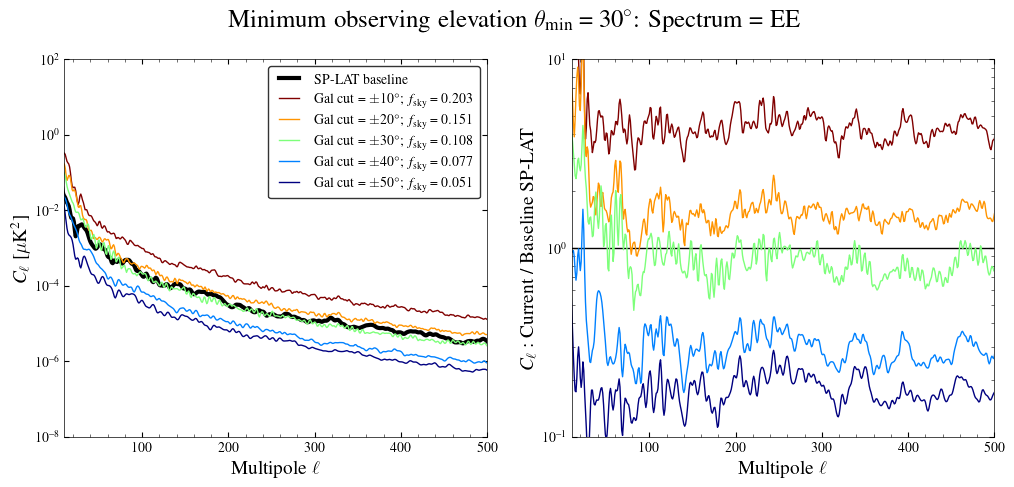

In [7]:
#now read the results file and show cl
reqd_min_obs_el = 30.
ell_norm = 80
xmin, xmax = 10, 500 #1000
for min_obs_el in min_obs_el_arr:

    #only showing min_obs_el = 30 degrees
    if min_obs_el != reqd_min_obs_el: continue

    print('\nAnalysing results for minimum observation elevation = %g degrees' %(min_obs_el))
    curr_hit_mask = result_dict['hit_masks'][min_obs_el]
    clf()
    fig = figure(figsize=(12, 5))
    color_arr = [cm.jet_r(int(d)) for d in np.linspace(0, 255, len(lat_masks_arr))]
    for iter in range(2):

        if iter == 0:
            ax=subplot(1,2,iter+1, yscale = 'log')
            ylabval = r'$C_{\ell}\ [\mu {\rm K}^{2}]$'
            ymin, ymax = 1e-8, 100.
        else:
            ax=subplot(1,2,iter+1, yscale = 'log')
            ylabval = r'$C_{\ell}:$ Current / Baseline SP-LAT'
            ymin, ymax = 0.1, 10.
            axhline(1., lw = 1.)

        if iter == 0:
            plot(el, cl_dust_fid, color = 'black', lw = 3., ls = '-', label = r'SP-LAT baseline')

        for latcntr, (bval) in enumerate( lat_masks_arr ):

            curr_lat_mask = result_dict['lat_masks'][bval]
            curr_total_mask = curr_hit_mask * curr_lat_mask
            curr_fsky_val = np.mean(curr_total_mask)

            cl_dust = result_dict['cl'][min_obs_el][bval][spec_ind]
            cl_dust = cl_dust[:lmax]/bl**2.
            cl_dust_ratio = cl_dust / cl_dust_fid

            colorval = color_arr[latcntr]
            #labval = r'$%g^{\circ} \le b \le %g^{\circ}$; $f_{\rm sky}=%.3f$' %(b1, b2, curr_fsky_val)
            labval = r'Gal cut = $\pm %g^{\circ}$; $f_{\rm sky}=%.3f$' %(bval, curr_fsky_val)
            if iter == 0:
                plot(el, cl_dust, color = colorval, label = labval, lw = 1.); 
                #plot(el, cl_dust_fit, ls = '--', color = colorval, label = r'SPLAT-Baseline')
            else:
                plot(el, cl_dust_ratio, color = colorval, label = labval, lw = 1.); 

        xlim(xmin, xmax); ylim(ymin, ymax)
        xlabel(r'Multipole $\ell$', fontsize = 14)
        ylabel(ylabval, fontsize = 14)
        #axvline(ell_norm, ls = '-.');
        if which_spec == 'TT':
            legloc = 3
        elif which_spec == 'EE':
            legloc = 1
        if iter == 0:
            legend(loc = legloc, fontsize = 10, ncol = 1)
    titleval = r'Minimum observing elevation $\theta_{\rm min} = %g^{\circ}$: Spectrum = %s' %(min_obs_el, which_spec)
    suptitle(titleval, fontsize = 18)
    show(); 

# Create a table: min_obs_el, fsky, gal cut, and ratio of dust power in the current patch over the baseline footprint at \ell=80.

In [8]:
cl_ratio_threshold = 10. #ignore footprint when dust power is factor of xx higher than the baseline footprint
#el_min_max_for_averaging = [60., 100.]
el_min_max_for_averaging = [70., 90.]
inds_for_averaging = np.where( (el >= el_min_max_for_averaging[0]) & (el <= el_min_max_for_averaging[1]) )[0]
print('el_min_obs \tLat mask[+/-xx]\t\tfsky\tDust power (%s: %g <= \ell <= %g): Current/Baseline SP-LAT' %(which_spec, el_min_max_for_averaging[0], el_min_max_for_averaging[1]))
for min_obs_el in min_obs_el_arr:    
    for latcntr, (bval) in enumerate( lat_masks_arr ):

        #get fsky
        curr_lat_mask = result_dict['lat_masks'][bval]
        curr_total_mask = curr_hit_mask * curr_lat_mask
        curr_fsky_val = np.mean(curr_total_mask)

        #get dust Cl
        cl_dust = result_dict['cl'][min_obs_el][bval][spec_ind]
        cl_dust = cl_dust[:lmax]/bl**2.

        #get Cl/Cl_baseline
        cl_ratio = np.median( cl_dust[inds_for_averaging] / cl_dust_fid[inds_for_averaging] )
        if cl_ratio>cl_ratio_threshold: continue
        
        print('%g degrees\t+/-%.1f degrees\t\t%.3f\t%.2f' %(min_obs_el, bval, curr_fsky_val, cl_ratio))
    print('\n')

el_min_obs 	Lat mask[+/-xx]		fsky	Dust power (EE: 70 <= \ell <= 90): Current/Baseline SP-LAT
20 degrees	+/-10.0 degrees		0.203	3.25
20 degrees	+/-20.0 degrees		0.151	1.12
20 degrees	+/-30.0 degrees		0.108	0.72
20 degrees	+/-40.0 degrees		0.077	0.28
20 degrees	+/-50.0 degrees		0.051	0.15


25 degrees	+/-10.0 degrees		0.203	3.46
25 degrees	+/-20.0 degrees		0.151	1.15
25 degrees	+/-30.0 degrees		0.108	0.75
25 degrees	+/-40.0 degrees		0.077	0.23
25 degrees	+/-50.0 degrees		0.051	0.14


30 degrees	+/-10.0 degrees		0.203	3.78
30 degrees	+/-20.0 degrees		0.151	1.07
30 degrees	+/-30.0 degrees		0.108	0.69
30 degrees	+/-40.0 degrees		0.077	0.23
30 degrees	+/-50.0 degrees		0.051	0.14


35 degrees	+/-10.0 degrees		0.203	3.92
35 degrees	+/-20.0 degrees		0.151	1.19
35 degrees	+/-30.0 degrees		0.108	0.64
35 degrees	+/-40.0 degrees		0.077	0.24
35 degrees	+/-50.0 degrees		0.051	0.15


40 degrees	+/-10.0 degrees		0.203	3.96
40 degrees	+/-20.0 degrees		0.151	1.18
40 degrees	+/-30.0 degrees		0.108	0.65
40

# Let us visualise some maps below now
## Baseline SP-LAT hit map (normalised) and Dust map @ 145 GHz from pySM

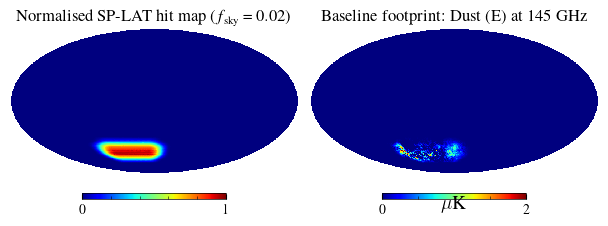

In [9]:
#calculate SP-LAT baseline again
minval, maxval = 0., 2. #50.
dust_map = H.read_map('data/cmbs4_dust_uKCMB_LAT-MFL2_nside512_dust_0000.fits', field = (0,1,2))
if which_spec == 'TT':
    dust_map = dust_map[0]
    dust_map_str = 'T'
elif which_spec == 'EE':
    dust_map = dust_map[1]
    dust_map_str = 'E'
hit_map = H.read_map('data/cmbs4_hitmap_LAT-MFPL1_pole_nside512_1_of_1.fits')
hit_map = hit_map / np.max(hit_map)
#fsky=np.sum(hit_map[hit_map>0.]/len(hit_map))
#fsky=len( np.where(hit_map>0.3)[0] )/len(hit_map)
fsky=np.mean(hit_map)
H.mollview(hit_map, sub = (121), min = 0., max = 1., title = r'Normalised SP-LAT hit map ($f_{\rm sky} = %.2f$)' %(fsky));
H.mollview(dust_map * hit_map, sub = (122), unit = r'$\mu$K', min = minval, max = maxval, title = r'Baseline footprint: Dust (%s) at 145 GHz' %(dust_map_str)); 
show()



# show all (hit/lat) masks


Analysing results for minimum observation elevation = 30 degrees


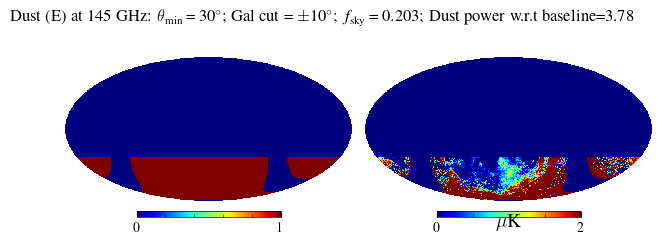

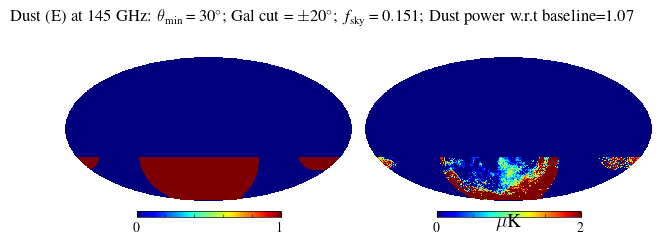

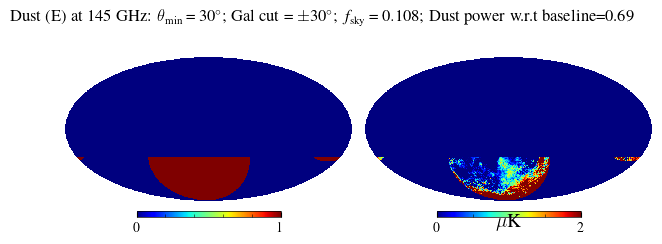

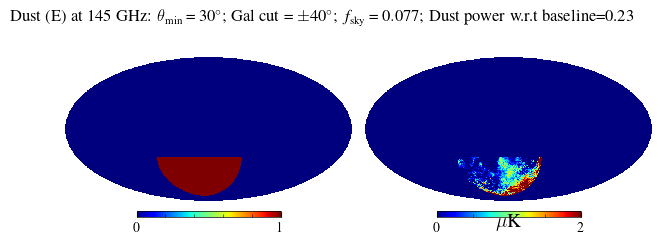

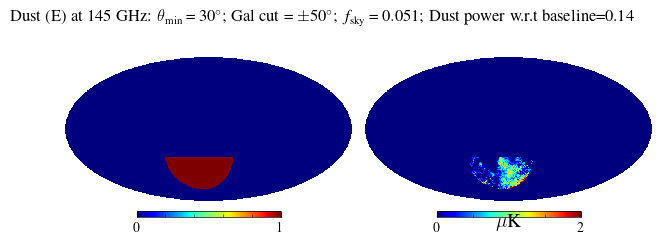

In [10]:
for min_obs_el in min_obs_el_arr:
    #only showing min_obs_el = 30 degrees
    if min_obs_el != reqd_min_obs_el: continue

    print('\nAnalysing results for minimum observation elevation = %g degrees' %(min_obs_el))
    curr_hit_mask = result_dict['hit_masks'][min_obs_el]
    for bval in lat_masks_arr:
        curr_lat_mask = result_dict['lat_masks'][bval]
        curr_total_mask = curr_lat_mask * curr_hit_mask        
        #curr_dust_map = np.copy( dust_145ghz ) * curr_total_mask
        curr_dust_map = np.copy( dust_map ) * curr_total_mask
        #curr_fsky_val = len( np.where(curr_total_mask>0.)[0] )/len(curr_total_mask)
        curr_fsky_val = np.mean( curr_total_mask )

        #get dust Cl
        cl_dust = result_dict['cl'][min_obs_el][bval][spec_ind]
        cl_dust = cl_dust[:lmax]/bl**2.
        #get Cl/Cl_baseline
        cl_ratio = np.median( cl_dust[inds_for_averaging] / cl_dust_fid[inds_for_averaging] )        
        
        #titleval = r'Dust (%s) at 145 GHz: $\theta_{\rm min} = %g^{\circ}$; $%g^{\circ} \le b \le %g^{\circ}$; $f_{\rm sky}=%.3f$' %(dust_map_str, min_obs_el, b1, b2, curr_fsky_val)
        titleval = r'Dust (%s) at 145 GHz: $\theta_{\rm min} = %g^{\circ}$; Gal cut = $\pm %g^{\circ}$; $f_{\rm sky}=%.3f$; Dust power w.r.t baseline=%.2f' %(dust_map_str, min_obs_el, bval, curr_fsky_val, cl_ratio)
        clf()
        #figure(figsize=(6., 3.))
        suptitle(r'%s' %(titleval), x=0.45, y = 1.05, fontsize = 12)
        H.mollview(curr_total_mask, min = 0., max = 1., sub = (221), title = ''); 
        H.mollview(curr_dust_map, sub = (222), title = '', unit = r'$\mu$K', min = minval, max = maxval); 
        show(); 
        